# Magic ratio AFM force curve analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use(['seaborn-notebook','seaborn-whitegrid','seaborn-colorblind'])
from scipy.optimize import curve_fit, root_scalar
from scipy.stats import trimboth
from tqdm.notebook import tqdm 

C:\Users\richa\AppData\Local\Temp\ipykernel_22664\703158209.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use(['seaborn-notebook','seaborn-whitegrid','seaborn-colorblind'])
C:\Users\richa\AppData\Local\Temp\ipykernel_22664\703158209.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use(['seaborn-notebook','seaborn-whitegrid','seaborn-colorblind'])
C:\Users\richa\AppData\Local\Temp\ipykernel_22664\703158209.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are dep

In [3]:
matplotlib.rcParams['lines.markersize']=3
matplotlib.rcParams['figure.dpi']=96
matplotlib.rcParams['lines.linewidth']=1

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [51]:
%matplotlib notebook

In [5]:
from magic_afm.calculation import secant, mylinspace

## Load and clean up data

In [6]:
# Weird dependency, but helps share code between notebook and magic_afm package
%autoawait trio
import trio

In [8]:
from magic_afm.data_readers import convert_ardf, ARH5File

# filename=r"X:\Data\AFM\Cypher\2019-10-25\PDMSW0006.ARDF"
# filename=r"X:\Data\AFM\Cypher\2019-10-15\TMPMP0006.ARDF"
# filename=r"X:\Data\AFM\Cypher\2019-07-25\magic0001.ARDF"
filename = r"example_data\AC160s00.ARDF"
h5_fname = await convert_ardf(filename)
fvfile = ARH5File(h5_fname)
await fvfile.ainitialize()

In [9]:
def parse_notes(notes):
    if int(notes["ForceMapImage"]):
        k = float(notes["SpringConstant"])
        force_setpoint = float(notes["TriggerPoint"]) * 1e9
        z_rate = float(notes["ForceScanRate"])
        fs = float(notes["NumPtsPerSec"])
    elif int(notes["FastMapImage"]):
        k = float(notes["SpringConstant"])
        force_setpoint = float(notes["FastMapSetpointNewtons"]) * 1e9
        z_rate = float(notes["FastMapZRate"])
        fs = float(notes["NumPtsPerSec"])
    else:
        raise ValueError("Cannot identify data type: Neither ForceMap nor Fastmap")

    print(notes["ImageNote"])
    print("k =", k, "N/m")
    print("F =", force_setpoint, "nN")
    print("rate =", z_rate, "Hz")
    print("SamplingFreq fs =", fs, "Hz")
    return k,force_setpoint, z_rate, fs

k,force_setpoint, z_rate, fs = parse_notes(fvfile.notes)

AC160TS-R3 dynamic end ramp
k = 23.523 N/m
F = 75.0 nN
rate = 2.0161 Hz
SamplingFreq fs = 2000.0 Hz


In [10]:
Xz, Xd = await fvfile.get_all_curves()

# Reshape to "dataset" (samples,features) and generate views of deflection and displacement
im_r, im_c, X_cols = Xz.shape
Xz=np.reshape(Xz,(-1,X_cols))
Xd=np.reshape(Xd,(-1,X_cols))

In [11]:
Xz.shape

(30, 835)

## Resample dataset with linear or Fourier interpolation

Asylum default filter settings result in a cutoff frequency at 250xA_rate in the deflection channel and 25xA_rate in the z channel. Nyquist sampling would therefore be 500 points per indent, but 512 is better for FFT

In [12]:
from magic_afm.calculation import resample_dset
npts=512
split = int(npts * (fvfile.split/X_cols))

0.00043562412297439127


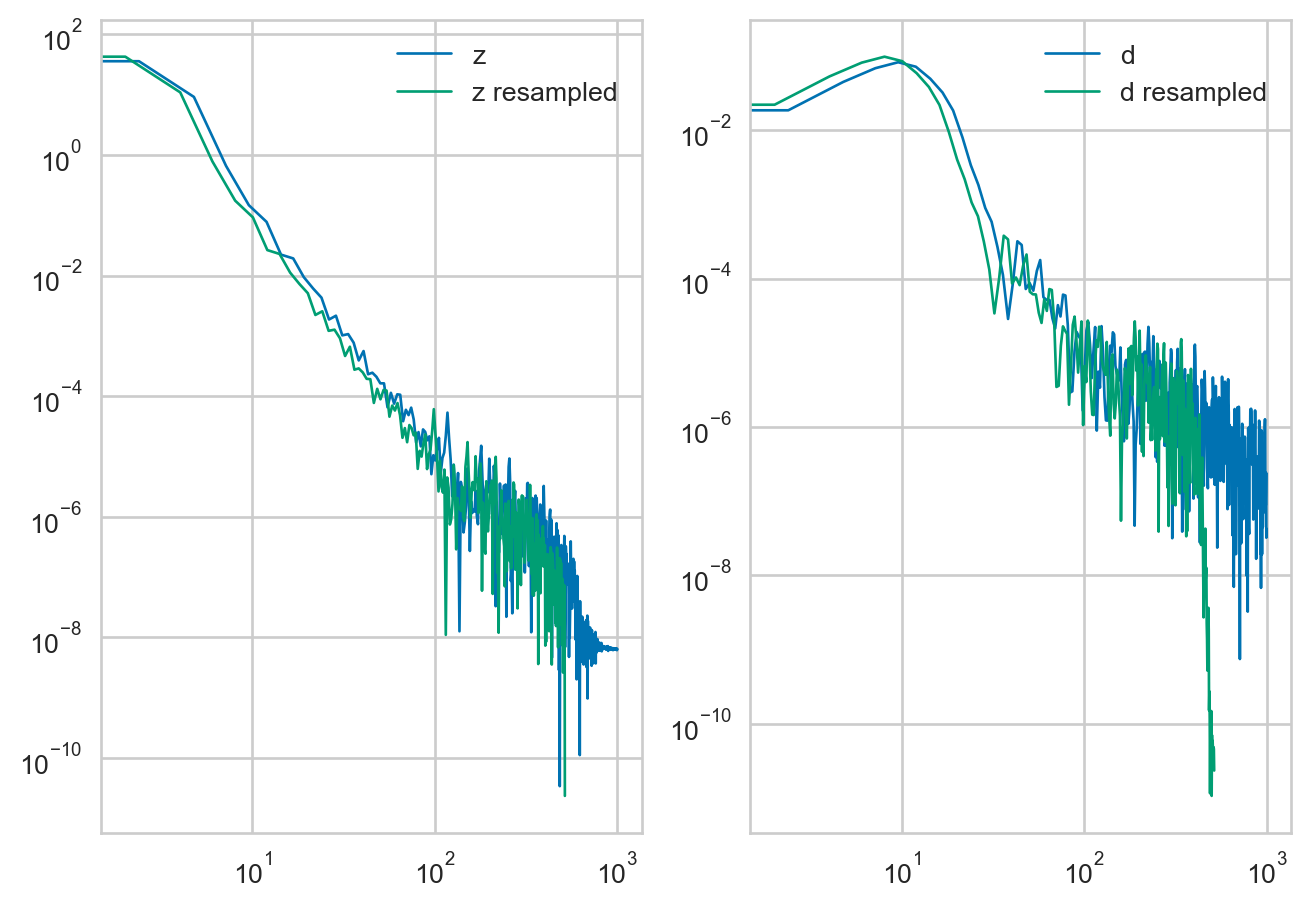

In [13]:
# visualize filter effect in power density spectrum
i=np.random.randint(len(Xz),size=1)
z=Xz[i]
d=Xd[i]
zsmp=resample_dset(z,npts,fourier=False)
# zsmp=np.interp(np.linspace(0,1,npts,False),np.linspace(0,1,z.shape[-1],False),z.squeeze())[None,:]
dsmp=resample_dset(d,npts,fourier=True)

from scipy.signal import periodogram
fig,(a1,a2)=plt.subplots(1,2)
opts = dict(window=('kaiser',6),detrend='linear',scaling='density')
a1.loglog(*periodogram(z.squeeze(),fs,**opts),label='z')
a1.loglog(*periodogram(zsmp.squeeze(),z_rate*npts,**opts),label='z resampled')
a1.legend()
# print(zsmp[:,-20:].mean())
a2.loglog(*periodogram(d.squeeze(),fs,**opts),label='d')
fd, pdd_den=periodogram(dsmp.squeeze(),z_rate*npts,**opts)
rms_noise = (pdd_den[-20:].mean()*z_rate*npts/2)**.5
print(rms_noise)
a2.loglog(fd, pdd_den,label='d resampled')
a2.legend()
None

In [14]:
# resample and regenerate views
Xz=resample_dset(Xz,npts,fourier=True)
Xd=resample_dset(Xd,npts,fourier=True)
#X=np.concatenate((Xz,Xd),axis=1)
#X_cols = X.shape[1]//2
#Xz=X[:,:X_cols]
#Xd=X[:,X_cols:]

## Inspect dataset

In [15]:
im_r, im_c, Xz.shape

(5, 6, (30, 512))

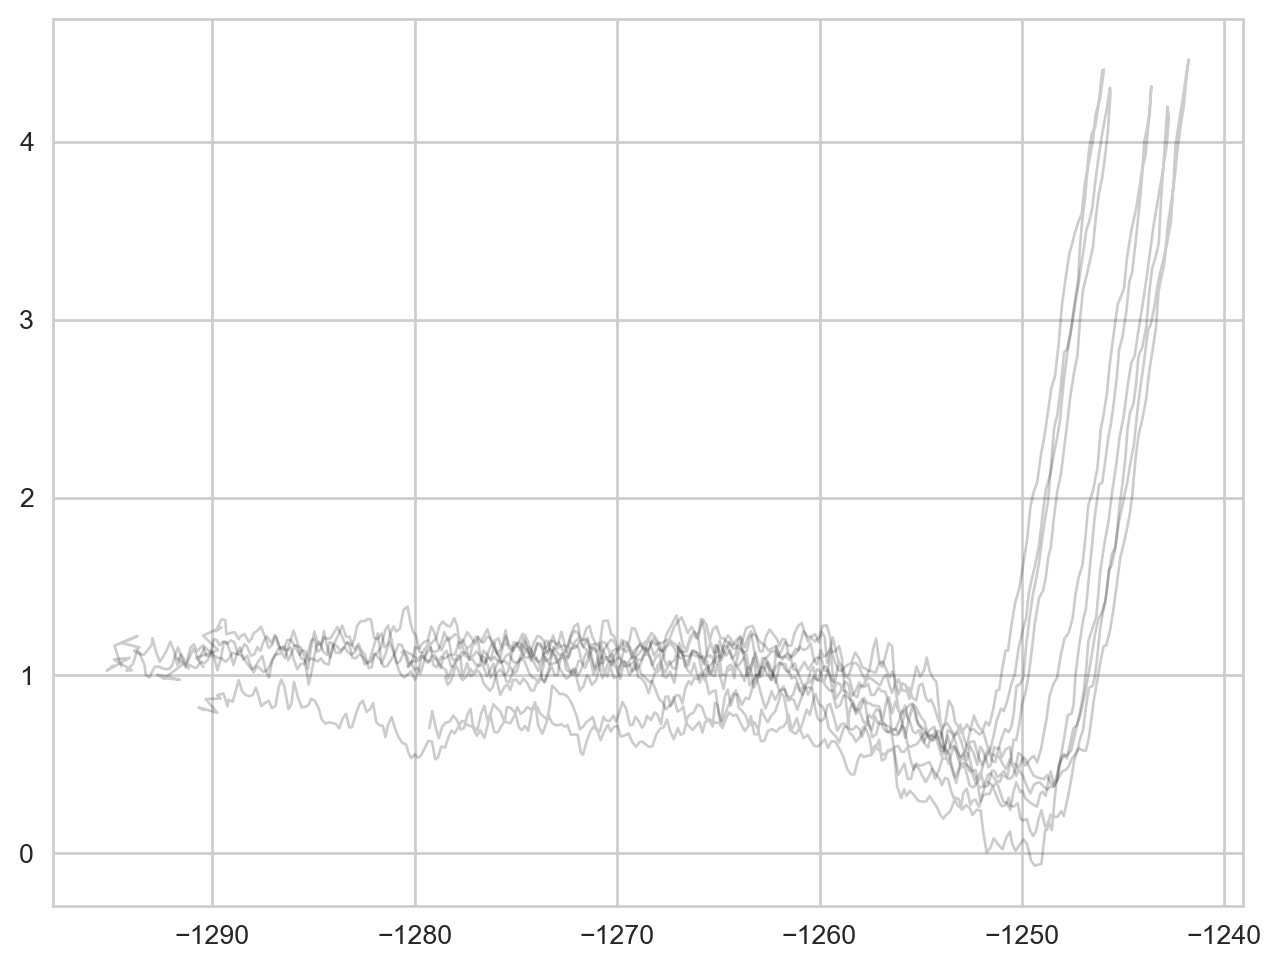

In [16]:
plt.figure(figsize=(8,6))
n=5
indices = np.random.randint(len(Xz),size=n)
plt.plot(Xz[indices,:].T,Xd[indices,:].T,alpha=1/n,color='black')
None

## Remove nuisance parameters if necessary

In [17]:
# #%%time

# # for piezo nuisance parameters
# t = np.linspace(0,2*np.pi,X_cols//2,endpoint=False)
# z = -np.cos(t)
# zprime = np.sin(t)
# zoffset= np.ones_like(t)
# zramp = np.linspace(0,1,X_cols//2,endpoint=False)
# # zoffsetdelta = np.concatenate((np.zeros(X_cols//4),np.ones(X_cols//4)))
# zrampdelta = np.concatenate((np.zeros(X_cols//4),np.linspace(0,.5,X_cols//4,endpoint=False)))

# # remove nuisance from z channel
# A=np.stack([z,zoffset,zramp],axis=-1)
# fit, res, rank, s = np.linalg.lstsq(A,Xz.T,rcond=None)
# znuisance=(A[:,1:]@fit[1:]).T
# Xz-=znuisance

# # remove nuisance from deflection channel
# A=np.stack([zoffset,],axis=-1)
# keep = np.ones(X_cols//2,dtype='bool')
# keep[X_cols//6:-X_cols//6] = False
# fit, res, rank, s = np.linalg.lstsq(A[keep,:],Xd.T[keep,:],rcond=None)
# dnuisance=(A@fit).T
# Xd-=dnuisance

## Model fitting: Schwarz contact 

In [18]:
from magic_afm.calculation import schwarz_red

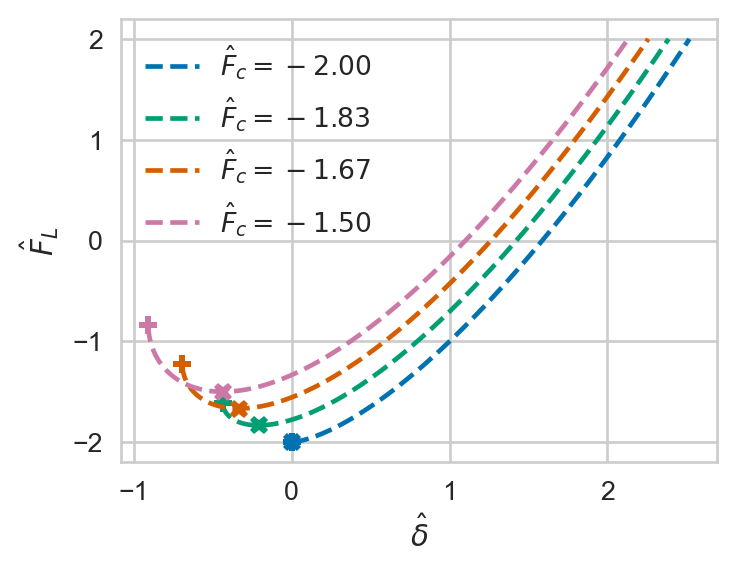

In [36]:
plt.figure(figsize=(4,3))
for red_fc in np.linspace(-2,-1.5,4).tolist():
    x0 = np.linspace((7*red_fc+8)/3,red_fc,1000,endpoint=False)
    x1 = np.linspace(red_fc,2,1000)
    y0 =schwarz_red(x0,red_fc,-1,0)
    y1 =schwarz_red(x1,red_fc,1,0)
    line=plt.plot(np.concatenate((y0,y1)),
                  np.concatenate((x0,x1)),
                  '--',
                  label=f"$\hat{{F}}_c={red_fc:0.2f}$"
                 )[0]
    
    # k=0 instability point (df/ddelta=inf)
    ai=((red_fc+2)/3)**(1/3)
    di=ai**2-4*(ai*(red_fc+2)/3)**.5
    plt.plot(di,(7*red_fc+8)/3,marker='P',ls='',c=line._color)
    # critical force (df/ddelta=0 trivial solution)
#     plt.axhline(red_fc,ls=':',c=line._color) #
    dc = schwarz_red(red_fc,red_fc,1,0)
    plt.plot(dc,red_fc,marker='X',ls='',c=line._color) 
plt.legend()
plt.xlabel("$\hat{\delta}$")
plt.ylabel("$\hat{F}_L$")
    # imaginary maximum unstable force (df/ddelta=0 other solution)
#     plt.axhline(4*red_fc+6,ls=':',c=line._color)
None

## Interpolate to locate spring snap off point

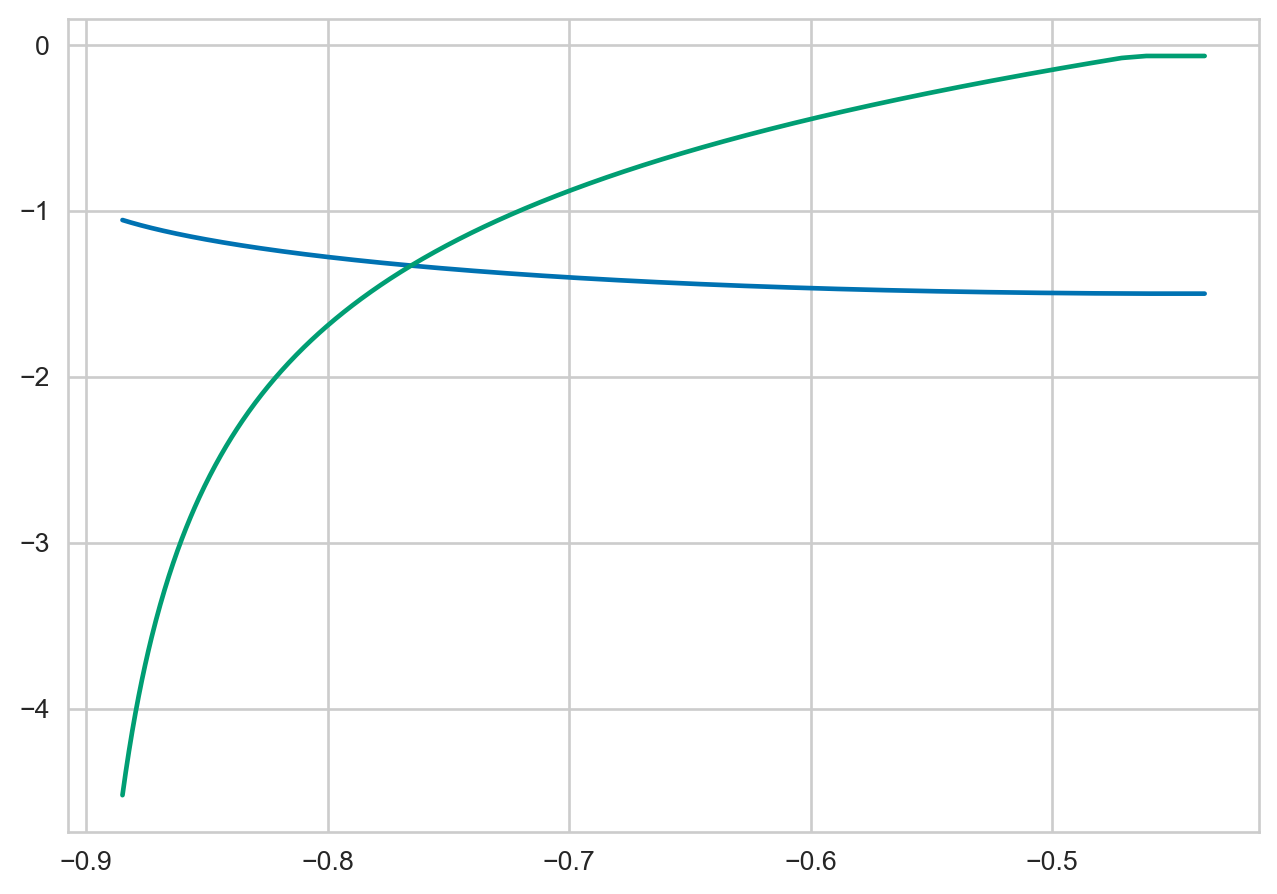

In [37]:
plt.figure()
w=np.linspace((di-dc)*.95+dc,dc,1003)
plt.plot(w,np.interp(w,y0,x0))
plt.plot(w,np.interp(w,y0,np.gradient(x0,y0)))
None

In [38]:
fc = -10
# ref_force = np.pi*gamma*radius
# red_fc = fc/ref_force
ref_force = fc/red_fc
radius= 70
K=.25
ref_radius = (ref_force*radius/K)**(1/3)
ref_depth = ref_radius*ref_radius/radius
red_k=-k/(ref_force)*(ref_depth)
print(red_k)

-7.641825372057767


In [39]:
root_scalar(lambda x: np.interp(x,y0,np.gradient(x0,y0))-red_k, bracket=(di,dc), method='brentq')

      converged: True
           flag: 'converged'
 function_calls: 15
     iterations: 14
           root: -0.8996656136934656

## model snap-in with L-J type potential
as Lin, D. C., Dimitriadis, E. K. and Horkay, F. (2007) ‘Robust Strategies for Automated AFM Force Curve Analysis—II: Adhesion-Influenced Indentation of Soft, Elastic Materials’, Journal of Biomechanical Engineering, 129(6), p. 904 but with a 9-3 LJ potential and finite k snap-in/out as KL, J. and JA, G. (1997) ‘An Adhesion Map for the Contact of Elastic Spheres’, Journal Of Colloid And Interface Science, 192(2), pp. 326–333. 
    

In [40]:
from magic_afm.calculation import lj_force, lj_gradient

In [41]:
delta = np.linspace(-2,0,1000)
force = lj_force(delta,-.6,red_fc,0,0)
gradient = lj_gradient(delta[delta<-.5],-.6,red_fc,0,0)

C:\Users\richa\Documents\GitHub\magic-afm\magic_afm\calculation.py:498: RuntimeWarning: divide by zero encountered in divide
  attraction = np.divide(1, (prefactor * nondim_position) ** lilpow)
C:\Users\richa\Documents\GitHub\magic-afm\magic_afm\calculation.py:499: RuntimeWarning: invalid value encountered in subtract
  return postfactor * force_scale * (attraction**powrat - attraction) - force_offset


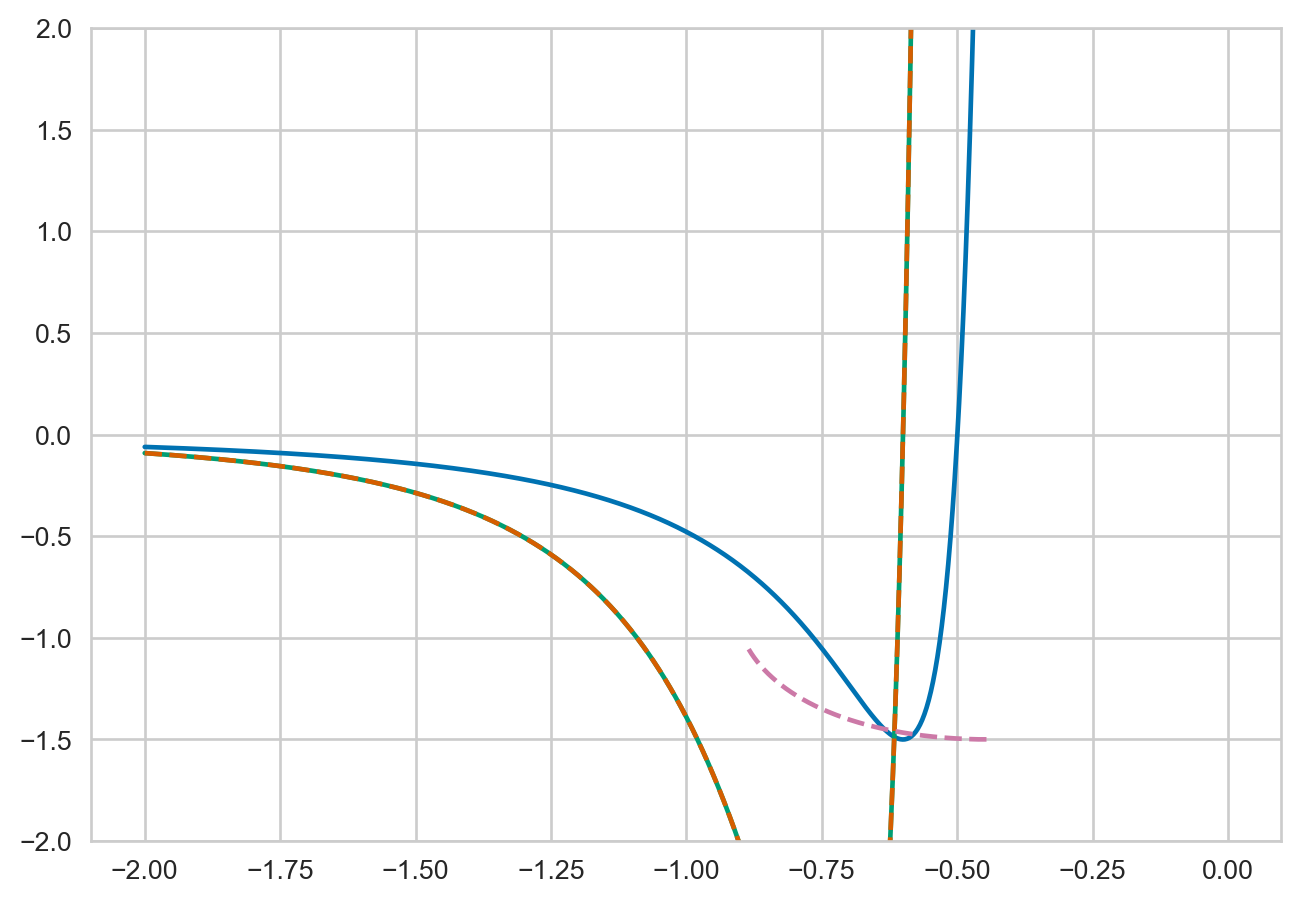

In [42]:
plt.figure()
plt.plot(delta,force)
plt.plot(delta[delta<-.5],gradient)
plt.plot(delta,np.gradient(force,delta),'--')
plt.ylim([-2,2])
_=plt.plot(w,np.interp(w,y0,x0),'--')

In [44]:
from magic_afm.calculation import lj_limit_factor
args = (-.6,red_k,0,red_k)
print('reduced k:',red_k)
print('min gradient:', lj_gradient(lj_limit_factor*args[0],*args))
print('bracket:',(2*args[1]-args[-2],lj_limit_factor*args[0]-args[-2]))
root_scalar(lj_gradient,args=args,bracket=(2*args[0]-args[-2],lj_limit_factor*args[0]-args[-2]))

reduced k: -7.641825372057767
min gradient: -11.026969499512209
bracket: (-15.283650744115533, -0.6989958304504277)


      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: -0.9795470260566482

## Generate dimensionless extend and retract curves

In [45]:
from magic_afm.calculation import red_extend

In [46]:
red_extend(np.linspace(-2,2,10),-1.752,red_k*.01,-.6,)

array([-0.04508524, -0.07756214, -0.11152581, -0.14548948, -0.17945315,
       -0.21341681, -0.24738048, -0.28134415,  0.38498632,  1.28004556])

<IPython.core.display.Javascript object>


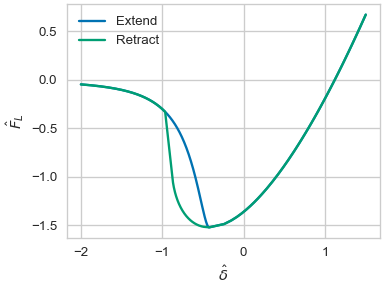

In [87]:
x=np.linspace(-2,1.5,1000)
y=red_extend(x,-1.52,red_k*1,-.6,)
# y=red_extend(x,-1.525,7.530771527978149,-10,10)
plt.figure(figsize=(4,3), layout="constrained")
plt.plot(x,y, label="Extend")
None

In [88]:
from magic_afm.calculation import red_retract

In [89]:
red_retract(np.linspace(-2,2,10),-1.752,red_k,-.33333,)

array([-0.01113968, -0.02309739, -0.06064276, -0.7050619 , -1.74015388,
       -1.51302874, -1.0374342 , -0.39393874,  0.38494545,  1.2800719 ])

In [90]:
y=red_retract(x,-1.52,red_k,-.6,)#4,0.1)
# plt.figure()
plt.plot(x,y, label="Retract")
None

In [91]:

plt.xlabel("$\hat{\delta}$")
plt.ylabel("$\hat{F}_L$")
plt.legend()

In [93]:
plt.savefig("tmp.svg",dpi=200)

## Scale model to real-space dimensions and fit to the data

In [ ]:
from magic_afm.calculation import force_curve,delta_curve,schwarz_wrap

In [ ]:
i=np.random.randint(len(Xz))
# i=1889
# i=(63-63)*64+1
fudgefactork=1.0
# z=np.mean(Xz, axis=0)
# d=np.mean(Xd, axis=0)/np.sqrt(fudgefactork)
z=Xz[i]
d=Xd[i]/np.sqrt(fudgefactork)
f=d*k*fudgefactork
delta = z-d
extsl=slice(split)
retsl=slice(split,None)

In [ ]:
plt.figure()
plt.plot(d)
plt.axvline(split,ls=':')
None

In [ ]:
from magic_afm.calculation import rapid_forcecurve_estimate
p0 = rapid_forcecurve_estimate(delta[retsl], f[retsl], radius)
print(p0)

In [ ]:
def partial_force_curve(delta, K, fc,  delta_shift, force_shift, 
                        lj_delta_scale,):
    return force_curve(red_retract, delta, k*fudgefactork, radius, K, -fc, tau, delta_shift, force_shift, 
                       lj_delta_scale,)
        
tau = .5
x,y = delta[retsl], f[retsl]
beta,cov=curve_fit(partial_force_curve, x,y, p0=p0, xtol=1e-9,ftol=1e-8,
                   bounds=np.transpose((
                       (0, np.inf),      # K
                       (0, np.inf),     # fc
                       (-np.inf,np.inf), # delta_shift
                       (-np.inf,np.inf), # force_shift
                       (0,200),          # lj_delta_scale
#                        (0, 1),           # tau
                   )),
                   method='trf', verbose=2, jac='2-point')

with np.printoptions(suppress=True,precision=3,linewidth=100):
    print(('K', 'fc', 'delta_shift', 'force_shift', 'lj_delta_scale', ))
    print(repr(np.stack((beta,np.sqrt(np.diag(cov)),100*np.sqrt(np.diag(cov))/beta))))

In [ ]:
# with matplotlib.style.context('seaborn-ticks'):
#     plt.figure(figsize=(4,4))
#     _=plt.imshow(cov)

In [ ]:
# confidence interval of predictions
from magic_afm.calculation import RT_EPS
xsort = np.linspace(x.min(),x.max(),1000)
yprimes = np.empty_like(y,shape=(len(beta),len(xsort)))
ypred = partial_force_curve(xsort, *beta,)
for j in range(len(yprimes)):
    thisbeta=beta.copy()
    dbeta = RT_EPS*beta[j]
    thisbeta[j]+=dbeta
    thisy = partial_force_curve(xsort, *thisbeta,)
    yprimes[j,:]= (thisy-ypred)/dbeta
    
yci = np.sqrt(np.diag(yprimes.T@cov@yprimes))

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(x-beta[2],(y-beta[3]-beta[1]),'.')

# plt.plot(delta[extsl],f[extsl],'.')
# f2=partial_force_curve(xsort-beta[2], *p0,)
# f3=partial_force_curve(x, *beta,) #ypred
# plt.plot(xsort-beta[2], f2-beta[3],':')
plt.plot(xsort-beta[2], (ypred-beta[3]-beta[1]),'-')
# plt.fill_between(xsort-beta[2],ypred-beta[3]+3*yci,ypred-beta[3]-3*yci,color='black',alpha=0.3)
# plt.axvline(beta[2])
# plt.xlim(beta[2]-2.5,beta[2]+2.5)
# plt.ylim(-110,-90)

plt.xlabel(r'Indentation $\delta$ (nm)')
plt.ylabel(r'Force $F$ (nN)')
None

In [ ]:
plt.figure()
plt.plot(x,y,'.')

plt.plot(delta[extsl],f[extsl],'.')
f2=partial_force_curve(xsort, *p0,)
# f3=partial_force_curve(x, *beta,) #ypred
plt.plot(xsort, f2,':')
plt.plot(xsort, ypred,'k:')
plt.fill_between(xsort,ypred+3*yci,ypred-3*yci,color='black',alpha=0.3)
plt.axvline(beta[2],ls=':')
plt.xlabel(r'Indentation $\delta$ (nm)')
plt.ylabel(r'Force $F$ (nN)')
# plt.xlim(beta[2]-2.5,beta[2]+2.5)
# plt.ylim(-110,-90)
#plt.savefig('test.svg')
None

In [ ]:
# plt.xlabel(r'Indentation depth $\delta$ (nm)')
# plt.ylabel(r'Indentation force $F$ (nN)')
# plt.title(' '.join(('F =', str(int(force_setpoint)),'nN')))

In [ ]:
# plt.gcf().set_size_inches(4,3)
# plt.tight_layout()

In [ ]:
print(cov[2,2]**.5,np.interp(0,xsort,yci))
z_true_surface = float(beta[2] + (partial_force_curve(beta[2], *beta,))/k)
z_true_surface_std=np.sqrt(cov[2,2]+np.interp(0,xsort,yci)**2)
print(f'z_true_surface {z_true_surface:.3f} ± {z_true_surface_std:.3f}')

In [ ]:
from magic_afm.calculation import calc_def_ind_ztru, FitMode
print(beta,radius,k,tau)
print(calc_def_ind_ztru(d[retsl],beta,radius,k,tau,FitMode.RETRACT))

## seems OK so try to fit a bunch of data

In [ ]:
from magic_afm.calculation import fitfun

In [ ]:
fudgefactork=1.05
radius = 30
tau=0
n=len(Xz)
inds = np.arange(n)
# inds = np.random.choice(len(X),size=n,replace=False)
fudgefactors=fudgefactork**-0.5

betas = np.empty((n,2,10)) # shape: datapoints, #sens + 1, #fitparms*2
for i in tqdm(inds, smoothing=1/24/5, desc='Fitting progress'):
    z=Xz[i]
    d=Xd[i]/np.sqrt(fudgefactork)
    d_fudge=d*fudgefactors
    f=d*k
    f_fudge=d*k*fudgefactork
    delta = z-d
    delta_fudge = z-d_fudge
    betas[i,0,:5],betas[i,0,5:],_=fitfun(delta,f,k,radius,tau,FitMode.RETRACT)
    betas[i,1,:5],betas[i,1,5:],_=fitfun(delta_fudge,f_fudge,k*fudgefactork,radius,tau,FitMode.RETRACT)

In [ ]:
abs_sens=(betas[:,1,:]-betas[:,0,:])/(fudgefactork-1)/k
rel_sens=(betas[:,1,:]-betas[:,0,:])/(fudgefactork-1)/betas[:,0,:]

In [ ]:
histdata=trimboth(rel_sens[:,0].T,.05)
histdata=histdata[~np.isnan(histdata)]
_=(histdata.mean(),histdata.std(),np.median(histdata))
print(*_,_[1]/_[0]*100)
plt.figure()
_=plt.hist(histdata, bins='auto', cumulative=False, density=True)

## calculate indentation ratio for each force curve from the data and fit

In [ ]:
# from magic_afm import calc_def_ind_ztru
# inds = np.random.choice(np.arange(len(X)),size=2,replace=False)
# inds = np.arange(n)
# radius,tau = 10,0
deflections=np.full(inds.shape,np.nan)
indentations=np.full(inds.shape,np.nan)
z_true_surfaces=np.full(inds.shape,np.nan)
for i in range(n):
    if np.any(np.isnan(betas[i,0,:])):
        continue
    K, fc, delta_shift, force_shift, lj_delta_scale,*_ = betas[i,0,:]
    z = Xz[i]
    z = z[retsl]
    d = Xd[i]
    d = d[retsl]
    delta=z-d
    force = force_curve(red_retract, delta, k, radius, K, -fc, tau, 
                               delta_shift, force_shift, lj_delta_scale,) # for plotting in next cells

    deflections[i],indentations[i],z_true_surfaces[i],_=calc_def_ind_ztru(force,betas[i,0,:],radius,k,tau,FitMode.RETRACT)

In [ ]:
print('deflection,   indentation,   deflection/indentation')
print(deflections[i],indentations[i], deflections[i]/indentations[i])
delta=z-d
with plt.style.context({'axes.titlesize':17,'axes.labelsize':15,'xtick.labelsize':12,'ytick.labelsize':12}):
    plt.figure(figsize=(4*1.5,3*1.5))
    _=plt.plot(delta-delta_shift,d-force_shift/k,'.',alpha=.75)
    _=plt.plot(delta-delta_shift,(force-force_shift)/k,'k')
    snapoff_offset=(delta-delta_shift)[np.argmin(force)]
    _=plt.plot(snapoff_offset,fc/k,'s')
    _=plt.plot(indentations[i]+snapoff_offset,deflections[i]+fc/k,'rX',ms=10)
#     _=plt.xlim(-25,5)
#     _=plt.ylim(bottom=-.5)
    _=plt.xlabel(r'Indentation $\delta$ (nm)')
    _=plt.ylabel(r'Deflection $d$ (nm)')
    _=plt.title(r'Example $d$ vs. $\delta$ curve, shifted')
_=plt.plot(0,(force_curve(red_retract, delta_shift, k, radius, K, -fc, tau, 
                               delta_shift, force_shift, lj_delta_scale,)-force_shift)/k,'rP',ms=10)
# )CAN IT BE DONE for F<Fmax BY TRUNCATING DATA?

In [ ]:
print('deflection,   indentation,   deflection/indentation')
# i=np.random.choice(np.arange(len(X)))
print(deflections[i],indentations[i], deflections[i]/indentations[i], z_true_surfaces[i])
plt.figure()
_=plt.plot(z,d,'.')
_=plt.plot(z,(force)/k,'k')
# _=plt.plot(z[i],deflections[i]+fc/k,'x')
# _=plt.plot((z)[np.argmin(force)],(fc+force_shift)/k,'P')
_=plt.plot(z_true_surfaces[i],(force_curve(red_retract, delta_shift, k, radius, K, -fc, tau, 
                               delta_shift, force_shift, lj_delta_scale,))/k,'rP',ms=10)
_=plt.xlabel(r'Z displacement $z$ (nm)')
_=plt.ylabel(r'Deflection w/offset $d$ (nm)')
_=plt.title('Location of true surface visualized')
# )CAN IT BE DONE for F<Fmax BY TRUNCATING DATA?

## Put it all together in summary plots

In [ ]:
# save above analysis in a dict according to filename
saved = {}
saved[filename]= deflections, indentations, betas, k, int(round(force_setpoint)), int(round(z_rate))

In [ ]:
sensfig,((sensratax,sensindax,sensdefax),
         (modratax,modindax,moddefax))=plt.subplots(2,3,figsize=(9,6),sharex='col',sharey='row')
thresh = .03
s=10
centroid=np.median
poisson=0.350

leg=[]
for fn in saved:
    if fn in {
#         r"X:\Data\AFM\Cypher\2019-07-25\magic0010.ARDF",
#         r"X:\Data\AFM\Cypher\2019-07-25\magic0009.ARDF",
#         r"X:\Data\AFM\Cypher\2019-07-25\magic0002.ARDF",
#         r"X:\Data\AFM\Cypher\2019-07-25\magic0005.ARDF",
    }:
        continue
    deflections, indentations, betas, k, force_setpoint, z_rate = saved[fn]
#     force_setpoint, z_rate=int(round(force_setpoint)), int(round(z_rate))
    if force_setpoint != 50:
        pass
    
    ratios=(deflections)/indentations
#     abs_sens=(betas[:,1,:]-betas[:,0,:])/(fudgefactork-1)/k
    rel_sens=(betas[:,1,:]-betas[:,0,:])/(fudgefactork-1)/betas[:,0,:]
    sens=rel_sens[:,0]
    moduli = (1-poisson**2)*betas[:,0,0]/(4/3)

    lo,hi = np.nanquantile(sens,(thresh,1-thresh))
    keep = (lo < sens) & (sens < hi)
    lo,hi = np.nanquantile(ratios,(thresh,1-thresh))
    keep &= (lo < ratios) & (ratios < hi) #& (.1 < ratios)
    alpha = min(100/sum(keep),1)
#     alpha /= (np.pi*sigmas*sigmas)
#     alpha /= alpha.max()*5
#     c=np.array(to_rgb(line.get_color()))
#     c=np.concatenate((np.broadcast_to(c,(len(sigmas),3)),alpha[:,np.newaxis]),axis=-1)

    deflections = deflections[keep]
    indentations = indentations[keep]
    ratios = ratios[keep]
    sens = sens[keep]
    moduli = moduli[keep]
    
    # style settings
    # could set color here instead of using default cycle
    scatter_style = dict(s=s,alpha=alpha, linewidth=0) 
    centroid_style = dict(marker='x',color='black',zorder=3)
    
    # sensratax => sensitivity vs ratio axes
    p=np.polyfit(ratios,sens,1)
    x=np.linspace(lo,hi)
    y=np.polyval(p,x)
    line,=sensratax.plot(x,y,':')
    # sensax.hist2d(ratios,sens,
    #            bins=150,cmin=0,density=True,cmap='Greys',
    #           range=((0,.7),(0,.5)),
    # #           range=((0,.75),(0,.0175)),
    #           )
#     sigmas=betas[keep,0,5]/betas[keep,0,0]
#     s = 300*sigmas
    sensratax.scatter(ratios,sens,**scatter_style)
    sensratax.scatter(centroid(ratios),centroid(sens),**centroid_style)
#     sensax.set_xlabel(r'Indentation ratio $\frac{d}{\delta}$')
    #     sensax.set_xlim((0,.7))
    #     sensax.set_ylim((0,.5))
    
    # modratax => modulus vs ratio axes
    p=np.polyfit(ratios,moduli,1)
    x=np.linspace(lo,hi)
    y=np.polyval(p,x)
    modratax.plot(x,y,':')
    modratax.scatter(ratios,moduli,**scatter_style)
    modratax.scatter(centroid(ratios),centroid(moduli),**centroid_style)
    
    # sensindax => sensitivity vs indentation axes
    lo,hi = np.nanquantile(indentations,(thresh,1-thresh))
    p=np.polyfit(indentations,sens,1)
    x=np.linspace(lo,hi)
    y=np.polyval(p,x)
    sensindax.plot(x,y,':')
    sensindax.scatter(indentations,sens,**scatter_style)
    sensindax.scatter(centroid(indentations),centroid(sens),**centroid_style)
    
    # modindax => modulus vs indentation axes
    p=np.polyfit(indentations,moduli,1)
    x=np.linspace(lo,hi)
    y=np.polyval(p,x)
    modindax.plot(x,y,':')
    modindax.scatter(indentations,moduli,**scatter_style)
    modindax.scatter(centroid(indentations),centroid(moduli),**centroid_style)
    
    # sensindax => sensitivity vs deflections axes
    lo,hi = np.nanquantile(deflections,(thresh,1-thresh))
    p=np.polyfit(deflections,sens,1)
    x=np.linspace(lo,hi)
    y=np.polyval(p,x)
    sensdefax.plot(x,y,':')
    sensdefax.scatter(deflections,sens,**scatter_style)
    sensdefax.scatter(centroid(deflections),centroid(sens),**centroid_style)
    
    # modindax => modulus vs deflections axes
    p=np.polyfit(deflections,moduli,1)
    x=np.linspace(lo,hi)
    y=np.polyval(p,x)
    moddefax.plot(x,y,':')
    moddefax.scatter(deflections,moduli,**scatter_style)
    moddefax.scatter(centroid(deflections),centroid(moduli),**centroid_style)
    
    leg.append((force_setpoint,z_rate))
    

# sensratax.relim()
# modratax.relim()
# sensindax.relim()
# modindax.relim()
# sensdefax.relim()
# moddefax.relim()
# sensratax.set_ylim(top=1.0)
# modratax.set_ylim(bottom=-0.025,top=.375)
# modratax.set_xlim(left=0.5)
# modindax.set_xlim(left=0.0)

sensdefax.legend([f'{(force_setpoint)} nN, {(z_rate)} Hz' for force_setpoint,z_rate in leg],loc='upper right')
sensratax.axhline(0,color='black',linestyle=':')
sensindax.axhline(0,color='black',linestyle=':')
sensdefax.axhline(0,color='black',linestyle=':')
sensratax.set_ylabel(r'Rel. modulus sens. $\frac{dE}{dk} \times \frac{k}{E}$')
modratax.set_xlabel(r'Indentation ratio $\frac{d_m}{\delta_m}$')
modratax.set_ylabel(r'Modulus $E$')
modindax.set_xlabel(r'Indentation depth $\delta_m$')
moddefax.set_xlabel(r'Deflection $d_m$')
sensfig.tight_layout()
sensfig.align_labels()

In [ ]:
# sensfig.savefig('ratio vs sens.png',dpi=300)

In [ ]:
from scipy.stats import probplot
plt.figure()
probplot(ratios,plot=plt)
probplot(rel_sens[:,0],plot=plt)
None

In [ ]:
# maxforces = Xd[:,:len(Xd[0])//25].mean(axis=-1)*k/
# deflections, indentations, betas, k, force_setpoint, z_rate=saved[r"X:\Data\AFM\Cypher\2019-07-25\magic0003.ARDF"]
# histdata=trimboth(betas[:,0,0],.001)
# print(np.nanmean(histdata),np.nanstd(histdata),len(histdata))
# plt.figure()
# _=plt.hist(histdata, bins='auto', cumulative=False, density=True)

In [ ]:
saved.keys()

## Copy of key cells for convenience
The above cells are the canonical implementations. Those below should be updated from time to time by copying.

In [ ]:
saved={}

In [ ]:
# Weird dependency, but helps share code between notebook and magic_afm package
%autoawait trio
import trio

In [ ]:
from magic_afm.data_readers import convert_ardf, ARH5File

# filename=r"X:\Data\AFM\Cypher\2019-10-25\PDMSW0006.ARDF"
# filename=r"X:\Data\AFM\Cypher\2019-10-15\TMPMP0006.ARDF"
# filename=r"X:\Data\AFM\Cypher\2019-07-25\magic0001.ARDF"
filename = r"example_data\AC160s00.ARDF"
h5_fname = await convert_ardf(filename)
fvfile = ARH5File(h5_fname)
await fvfile.ainitialize()

Xz, Xd = await fvfile.get_all_curves()

# Reshape to "dataset" (samples,features) and generate views of deflection and displacement
im_r, im_c, X_cols = Xz.shape
Xz=np.reshape(Xz,(-1,X_cols))
Xd=np.reshape(Xd,(-1,X_cols))

In [ ]:
from magic_afm.calculation import resample_dset

k,force_setpoint, z_rate, fs = parse_notes(fvfile.notes)
print('Points per curve =',X_cols//2)
print('Data dtype =', Xz.dtype)

# resample
npts=512
split = int(npts * (fvfile.split/X_cols))
Xz=resample_dset(Xz,npts,fourier=False)
Xd=resample_dset(Xd,npts,fourier=True)

In [ ]:
from magic_afm.calculation import fitfun
fudgefactork=1.05
radius = 30
tau=0
n=len(Xz)
inds = np.arange(n)
# inds = np.random.choice(len(X),size=n,replace=False)
fudgefactors=fudgefactork**-0.5

betas = np.empty((n,2,10)) # shape: datapoints, #sens + 1, #fitparms*2
for i in tqdm(inds, smoothing=1/24/5, desc='Fitting progress'):
    z=Xz[i]
    d=Xd[i]/np.sqrt(fudgefactork)
    d_fudge=d*fudgefactors
    f=d*k
    f_fudge=d*k*fudgefactork
    delta = z-d
    delta_fudge = z-d_fudge
    betas[i,0,:5],betas[i,0,5:],_=fitfun(delta,f,k,radius,tau,FitMode.RETRACT)
    betas[i,1,:5],betas[i,1,5:],_=fitfun(delta_fudge,f_fudge,k*fudgefactork,radius,tau,FitMode.RETRACT)

In [ ]:
from magic_afm.calculation import calc_def_ind_ztru
deflections=np.full(n,np.nan)
indentations=np.full(n,np.nan)
z_true_surfaces=np.full(n,np.nan)
for i in range(n):
    if np.any(np.isnan(betas[i,0,:])):
        continue
    K, fc, delta_shift, force_shift, lj_delta_scale,*_ = betas[i,0,:]
    z = Xz[i]
    z = z[split:]
    d = Xd[i]
    d = d[split:]
    delta=z-d
    force = force_curve(red_retract, delta, k, radius, K, -fc, tau, 
                               delta_shift, force_shift, lj_delta_scale,) # for plotting in next cells

    deflections[i],indentations[i],z_true_surfaces[i],_=calc_def_ind_ztru(force,betas[i,0,:],radius,k,tau,FitMode.RETRACT)

In [ ]:
saved[filename] = deflections, indentations, betas, k, int(round(force_setpoint)), int(round(z_rate))